In [197]:
# import libraries
import os
import pandas
import numpy
import datetime
from matplotlib import pyplot
import matplotlib
import statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.discrete.discrete_model import NegativeBinomial, Poisson
from scipy.stats import spearmanr, pearsonr, kendalltau, pointbiserialr, chi2
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import PoissonRegressor
from sklearn.pipeline import make_pipeline
import tensorflow_probability as tfp
import statsmodels.api as sm
 
# set plot characteristics
%matplotlib inline
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 25}
matplotlib.rc('font', **font)

In [198]:
# read and create train and test sets
data_path = r'bike-sharing-demand'
train = pandas.read_csv(os.path.join(data_path, 'train.csv'), parse_dates=['datetime'])
test = pandas.read_csv(os.path.join(data_path, 'test.csv'), parse_dates=['datetime'])
og = pandas.read_csv(os.path.join(data_path, 'hour.csv'), parse_dates=['dteday'])
cnts = []
for i in range(len(og)):
    if og['dteday'].iloc[i].day >= 20:
        cnts.append(og['cnt'].iloc[i])
test['count'] = cnts
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [199]:
# find index of first day in 2012 for both train and test sets
for i in range(len(train)):
    if train['datetime'].iloc[i].date() == datetime.date(2012,1,1): 
        print(i)
        break
for i in range(len(test)):
    if test['datetime'].iloc[i].date() == datetime.date(2012,1,20): 
        print(i)
        break

5422
3223


191.57413191254824 181.13613357426559


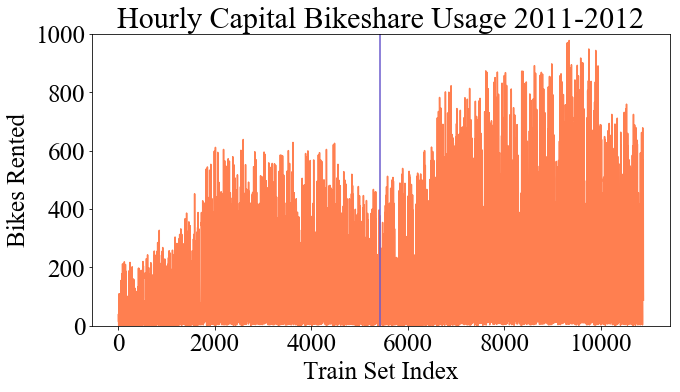

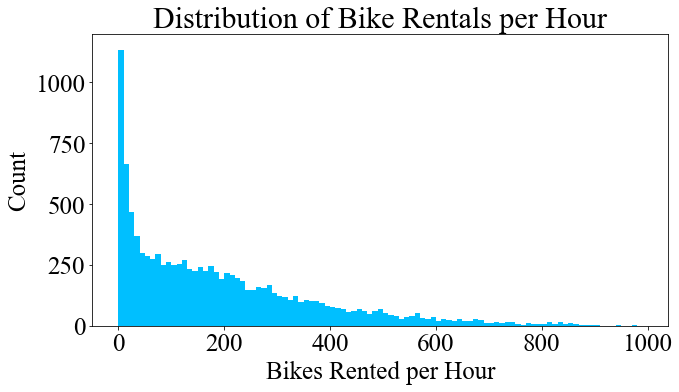

In [200]:
# plot time series of bike rentals per hour for train set
pyplot.figure(figsize=(10,6))
pyplot.plot(train['count'], '-', color='coral')
pyplot.axvline(x=5422, color='slateblue')
pyplot.xlabel('Train Set Index')
pyplot.ylabel('Bikes Rented')
pyplot.title('Hourly Capital Bikeshare Usage 2011-2012')
pyplot.ylim([0, 1000])
pyplot.tight_layout()
# pyplot.savefig('series_train.jpg')

# plot distribution of bike rentals per hour for train set
pyplot.figure(figsize=(10,6))
pyplot.hist(train['count'], bins=numpy.arange(0,1000,10), color='deepskyblue')
pyplot.ylabel('Count')
pyplot.xlabel('Bikes Rented per Hour')
pyplot.title('Distribution of Bike Rentals per Hour')
pyplot.ylim([0, 1200])
pyplot.tight_layout()
# pyplot.savefig('hist_train.jpg')

print(numpy.mean(train['count']), numpy.std(train['count']))

185.9237640535962 181.73947198920985


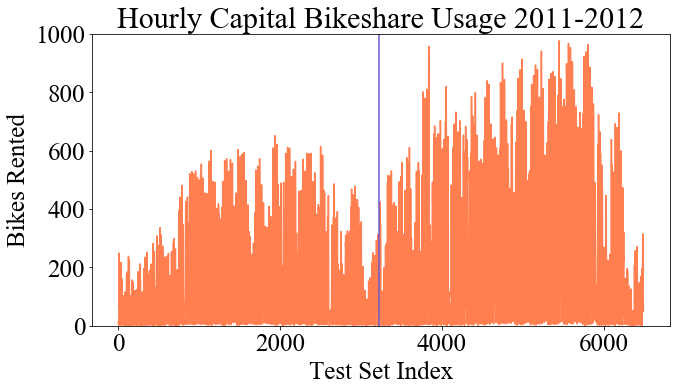

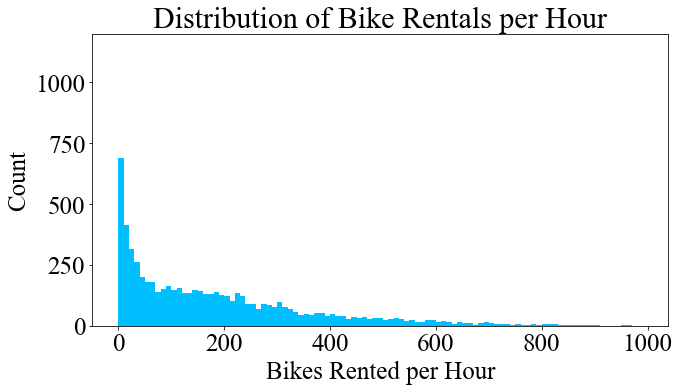

In [201]:
# plot time series of bike rentals per hour for test set
pyplot.figure(figsize=(10,6))
pyplot.plot(test['count'], '-', color='coral')
pyplot.axvline(x=3223, color='slateblue')
pyplot.xlabel('Test Set Index')
pyplot.ylabel('Bikes Rented')
pyplot.title('Hourly Capital Bikeshare Usage 2011-2012')
pyplot.ylim([0, 1000])
pyplot.tight_layout()
# pyplot.savefig('series_test.jpg')

# plot distribution of bike rentals per hour for train set
pyplot.figure(figsize=(10,6))
pyplot.hist(test['count'], bins=numpy.arange(0,1000,10), color='deepskyblue')
pyplot.ylabel('Count')
pyplot.xlabel('Bikes Rented per Hour')
pyplot.title('Distribution of Bike Rentals per Hour')
pyplot.ylim([0, 1200])
pyplot.tight_layout()
# pyplot.savefig('hist_test.jpg')

print(numpy.mean(test['count']), numpy.std(test['count']))

## Dataset Structuring

In [202]:
# create independent variables data structure and dependent variable data structure for train and test data
y_train = train['count']
datetime = train['datetime']
X_train = train.drop(labels=['datetime', 'casual', 'registered', 'count'], axis=1, inplace=False)
hour = pandas.Series([i.hour for i in datetime])
X_train.insert(0, 'hour', hour)
month = pandas.Series([i.month for i in datetime])
X_train.insert(0, 'month', month)

y_test = test['count']
datetime = test['datetime']
X_test = test.drop(labels=['datetime', 'count'], axis=1, inplace=False)
hour = pandas.Series([i.hour for i in datetime])
X_test.insert(0, 'hour', hour)
month = pandas.Series([i.month for i in datetime])
X_test.insert(0, 'month', month)

# create independent and dependent data structures for models trained by year
list2011, list2012 = [], []
for i in range(len(train)):
    if train['datetime'].iloc[i].year == 2011:
        list2011.append(train['count'].iloc[i])
    elif train['datetime'].iloc[i].year == 2012:
        list2012.append(train['count'].iloc[i])
y_train_2011 = pandas.Series(list2011)
X_train_2011 = X_train.iloc[:y_train_2011.size, :]
y_train_2012 = pandas.Series(list2012)
X_train_2012 = X_train.iloc[y_train_2011.size:, :]
X_train_2012.reset_index(drop=True, inplace=True)

list2011, list2012 = [], []
for i in range(len(test)):
    if test['datetime'].iloc[i].year == 2011:
        list2011.append(test['count'].iloc[i])
    elif test['datetime'].iloc[i].year == 2012:
        list2012.append(test['count'].iloc[i])
y_test_2011 = pandas.Series(list2011)
X_test_2011 = X_test.iloc[:y_test_2011.size, :]
y_test_2012 = pandas.Series(list2012)
X_test_2012 = X_test.iloc[y_test_2011.size:, :]
X_test_2012.reset_index(drop=True, inplace=True)

In [289]:
# helper functions
def get_pearson_stat(pred, gt): 
    return ((gt - pred)**2 / pred).sum()

def get_dispersion(pred, gt, Y):
    X_square = get_pearson_stat(pred, gt)
    df = pred.size - (Y.shape[1] + 1)
    return X_square / df, df

def plot_dist_compare(pred, y, title):
    pyplot.figure(figsize=(10,6))
    pyplot.hist(y, bins=numpy.arange(0,1000,10), label='Ground-truth', fc=(0, 0, 1, 1))
    pyplot.hist(pred, bins=numpy.arange(0,1000,10), label='Predicted', fc=(1, .66, .5, 0.5))
    pyplot.legend()
    pyplot.ylabel('Count')
    pyplot.xlabel('Bikes Rented per Hour')
#     pyplot.title(title)
    pyplot.ylim([0, 1200])
    pyplot.tight_layout()

def print_dispersion_stats(pred, y, X, year):
    X_square = get_pearson_stat(pred, y)
    D, df = get_dispersion(pred, y, X)
    print(year + ':')
    print('D =', D)
    print('p =', 1 - chi2.cdf(X_square, df))
    print('X^2 =', X_square)
    print('df =', df)
    print('\n')

def plot_series_compare(pred, y):
    pyplot.figure(figsize=(10,6))
    pyplot.plot(y, label='Ground-truth', color='slateblue')
    pyplot.plot(pred, label='Predicted', color='yellow', alpha=0.7)
    pyplot.legend()
    pyplot.xlabel('Data Point Index')
    pyplot.ylabel('Bikes Rented')
    pyplot.tight_layout()
    pyplot.ylim([0, 1500])
    
def get_RMSE(pred, y):
    rmse = numpy.sqrt(((y - pred)**2).sum()/y.size)
    return rmse

In [204]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## Fit Poisson Regression Model

In [245]:
# fit models for all data, 2011, and 2012
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

X_train_scaled = minmax_scaler.fit_transform(X_train)
X_train_scaled = pandas.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled['const'] = numpy.ones_like(X_train_scaled['month']) # add intercept 
model_all = sm.GLM(y_train, X_train_scaled, family=sm.families.Poisson()).fit()
pred_train_all = model_all.predict()

X_train_scaled_2011 = minmax_scaler.fit_transform(X_train_2011)
X_train_scaled_2011 = pandas.DataFrame(X_train_scaled_2011, columns=X_train_2011.columns)
X_train_scaled_2011['const'] = numpy.ones_like(X_train_scaled_2011['month']) # add intercept 
model_2011 = sm.GLM(y_train_2011, X_train_scaled_2011, family=sm.families.Poisson()).fit()
pred_train_2011 = model_2011.predict()

X_train_scaled_2012 = minmax_scaler.fit_transform(X_train_2012)
X_train_scaled_2012 = pandas.DataFrame(X_train_scaled_2012, columns=X_train_2012.columns)
X_train_scaled_2012['const'] = numpy.ones_like(X_train_scaled_2012['month']) # add intercept 
model_2012 = sm.GLM(y_train_2012, X_train_scaled_2012, family=sm.families.Poisson()).fit()
pred_train_2012 = model_2012.predict()

In [218]:
print(numpy.mean(y_train), numpy.mean(pred_train_all))
print(numpy.mean(y_train_2011), numpy.mean(pred_train_2011))
print(numpy.mean(y_train_2012), numpy.mean(pred_train_2012))

191.57413191254824 191.57413191254727
144.223349317595 144.22334931759642
238.56094436310394 238.56094436310292


In [220]:
print(numpy.var(y_train), numpy.var(pred_train_all))
print(numpy.var(y_train), numpy.var(pred_train_2011))
print(numpy.var(y_train), numpy.var(pred_train_2012))

32810.29888623418 12059.143361859413
32810.29888623418 7647.327110779987
32810.29888623418 16232.203194658792


In [210]:
print_dispersion_stats(pred_train_all, y_train, X_train_scaled, 'All')
print_dispersion_stats(pred_train_2011, y_train_2011, X_train_scaled_2011, '2011')
print_dispersion_stats(pred_train_2012, y_train_2012, X_train_scaled_2012, '2012')

All:
D = 123.19949289357636
p = 0.0
X^2 = 1339671.2857247493
df = 10874


2011:
D = 78.3632791415972
p = 0.0
X^2 = 423945.34015604085
df = 5410


2012:
D = 134.42643250545487
p = 0.0
X^2 = 732892.91001974
df = 5452




In [84]:
summary_all = model_all.summary()
results_as_html = summary_all.tables[1].as_html()
summary_all_df = pandas.read_html(results_as_html, header=0, index_col=0)[0]
summary_all_df.to_csv('Poisson_all_summary.csv')
summary_all

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  count   No. Observations:                10886
Model:                            GLM   Df Residuals:                    10875
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -6.0636e+05
Date:                Wed, 08 Dec 2021   Deviance:                   1.1431e+06
Time:                        20:19:49   Pearson chi2:                 1.34e+06
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
month          0.8664      0.009     91.620      0.000       0.848       0.885
hour           1.0415      0.003    396.007      0.000       1.036       1.047
season        -0.2497      0.008    -32.012      0.000      -0.265      -0.234
holiday       -0.0035      0.004     -0.787      0.431      -0.012       0.005
workingday     0.0023      0.002      1.485      0.138      -0.001       0.005
weather       -0.0418      0.004    -10.769      0.000      -0.049      -0.034
temp           0.0874      0.021      4.094      0.000       0.046       0.129
atemp          1.4348      0.022     64.966      0.000       1.392       1.478
humidity      -1.2072      0.004   -272.290      0.000      -1.216      -1.199
windspeed      0.2141      0.005     41.837      0.000       0.204       0.224
const          4.1796      0.005    918.746      0.000       4.171       4.189
==============================================================================
"""

In [87]:
summary_2011 = model_2011.summary()
results_as_html = summary_2011.tables[1].as_html()
summary_2011_df = pandas.read_html(results_as_html, header=0, index_col=0)[0]
summary_2011_df.to_csv('Poisson_2011_summary.csv')
summary_2011

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 5422
Model:                            GLM   Df Residuals:                     5411
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.0713e+05
Date:                Wed, 08 Dec 2021   Deviance:                   3.8099e+05
Time:                        20:20:27   Pearson chi2:                 4.24e+05
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
month          0.7416      0.016     47.697      0.000       0.711       0.772
hour           1.0931      0.004    256.508      0.000       1.085       1.101
season        -0.0390      0.013     -3.041      0.002      -0.064      -0.014
holiday        0.0424      0.007      5.946      0.000       0.028       0.056
workingday    -0.0518      0.003    -20.596      0.000      -0.057      -0.047
weather       -0.0652      0.004    -15.667      0.000      -0.073      -0.057
temp          -0.7252      0.042    -17.306      0.000      -0.807      -0.643
atemp          2.3667      0.044     53.288      0.000       2.280       2.454
humidity      -1.0244      0.007   -146.561      0.000      -1.038      -1.011
windspeed      0.2406      0.008     29.222      0.000       0.224       0.257
const          3.7013      0.007    502.444      0.000       3.687       3.716
==============================================================================
"""

In [85]:
summary_2012 = model_2012.summary()
results_as_html = summary_2012.tables[1].as_html()
summary_2012_df = pandas.read_html(results_as_html, header=0, index_col=0)[0]
summary_2012_df.to_csv('Poisson_2012_summary.csv')
summary_2012

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 5464
Model:                            GLM   Df Residuals:                     5453
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.4521e+05
Date:                Wed, 08 Dec 2021   Deviance:                   6.5406e+05
Time:                        20:19:54   Pearson chi2:                 7.33e+05
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
month          1.0466      0.012     86.667      0.000       1.023       1.070
hour           1.0215      0.003    305.633      0.000       1.015       1.028
season        -0.4602      0.010    -46.230      0.000      -0.480      -0.441
holiday       -0.0382      0.006     -6.815      0.000      -0.049      -0.027
workingday     0.0436      0.002     22.226      0.000       0.040       0.047
weather       -0.0310      0.005     -6.125      0.000      -0.041      -0.021
temp           0.2998      0.022     13.925      0.000       0.258       0.342
atemp          1.0044      0.022     45.353      0.000       0.961       1.048
humidity      -1.0078      0.005   -198.819      0.000      -1.018      -0.998
windspeed      0.2298      0.006     40.885      0.000       0.219       0.241
const          4.2942      0.005    815.373      0.000       4.284       4.305
==============================================================================
"""

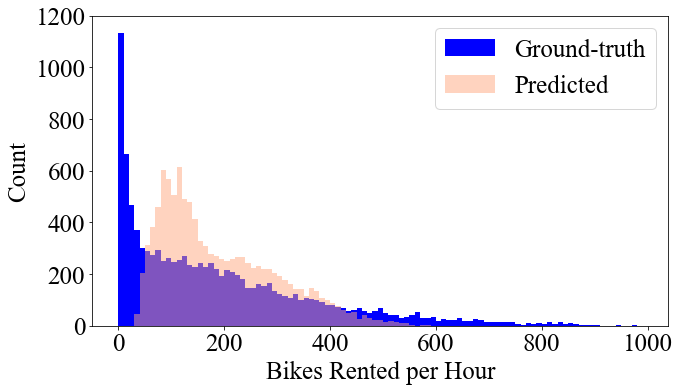

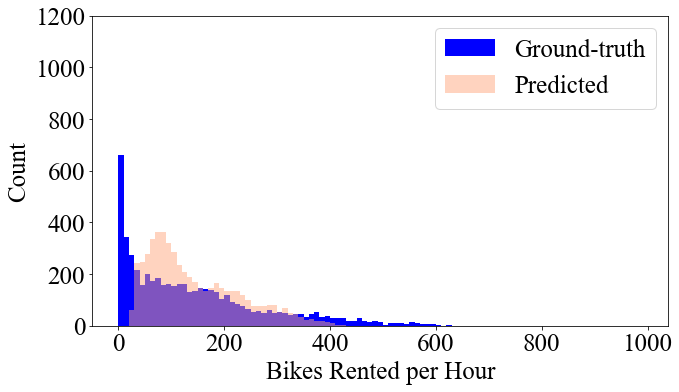

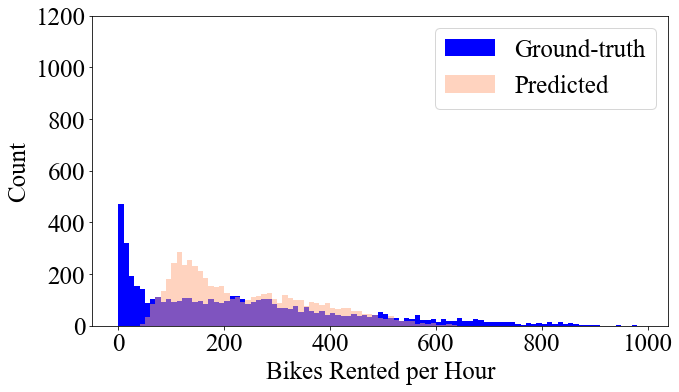

In [97]:
# plot distribution and predicted distribution bike rentals per hour
plot_dist_compare(pred_train_all, y_train, 'Distribution of Bike Rentals per Hour')
pyplot.savefig('all_dist.jpg')
plot_dist_compare(pred_train_2011, y_train_2011, 'Distribution of Bike Rentals per Hour 2011')
pyplot.savefig('2011_dist.jpg')
plot_dist_compare(pred_train_2012, y_train_2012, 'Distribution of Bike Rentals per Hour 2012')
pyplot.savefig('2012_dist.jpg')

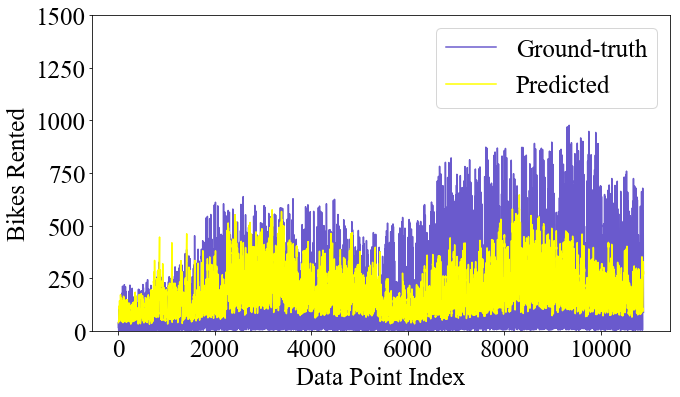

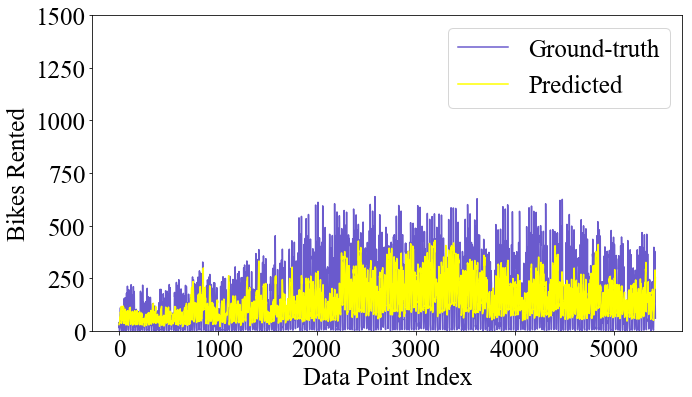

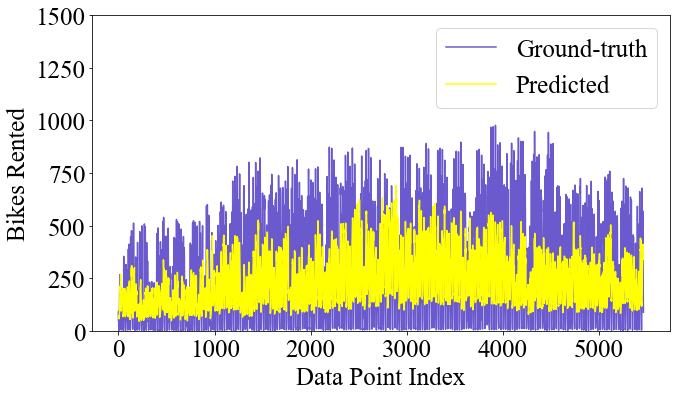

In [95]:
plot_series_compare(pred_train_all, y_train)
pyplot.savefig('all_series.jpg')
plot_series_compare(pred_train_2011, y_train_2011)
pyplot.savefig('2011_series.jpg')
plot_series_compare(pred_train_2012, y_train_2012)
pyplot.savefig('2012_series.jpg')

## Test Poisson Regression Model

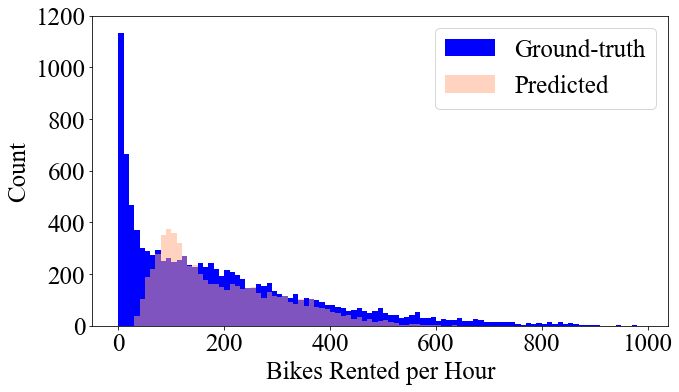

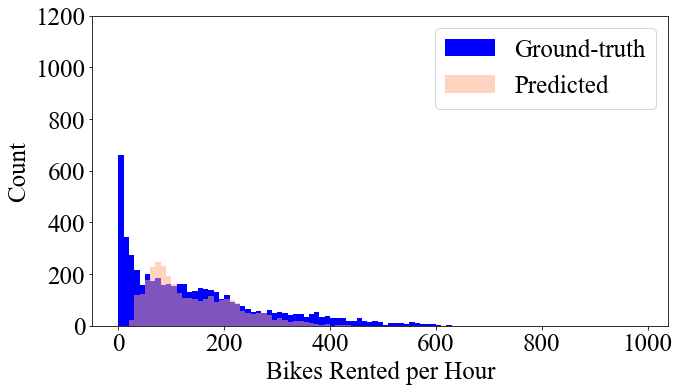

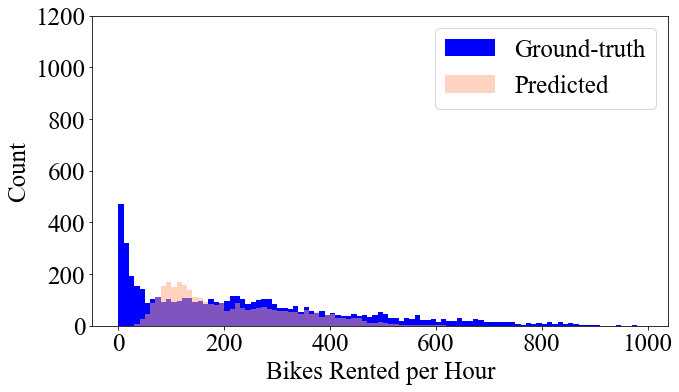

In [100]:
# plot distribution and predicted distribution bike rentals per hour test
X_test_scaled = minmax_scaler.fit_transform(X_test)
X_test_scaled = pandas.DataFrame(X_test_scaled, columns=X_test.columns)
X_test_scaled['const'] = numpy.ones_like(X_test_scaled['month']) # add intercept

X_test_scaled_2011 = minmax_scaler.fit_transform(X_test_2011)
X_test_scaled_2011 = pandas.DataFrame(X_test_scaled_2011, columns=X_test_2011.columns)
X_test_scaled_2011['const'] = numpy.ones_like(X_test_scaled_2011['month']) # add intercept

X_test_scaled_2012 = minmax_scaler.fit_transform(X_test_2012)
X_test_scaled_2012 = pandas.DataFrame(X_test_scaled_2012, columns=X_test_2012.columns)
X_test_scaled_2012['const'] = numpy.ones_like(X_test_scaled_2012['month']) # add intercept

pred_test_all = model_all.predict(X_test_scaled)
pred_test_2011 = model_2011.predict(X_test_scaled_2011)
pred_test_2012 = model_2012.predict(X_test_scaled_2012)

plot_dist_compare(pred_test_all, y_train, 'Distribution of Bike Rentals per Hour')
pyplot.savefig('all_dist_test.jpg')
plot_dist_compare(pred_test_2011, y_train_2011, 'Distribution of Bike Rentals per Hour 2011')
pyplot.savefig('2011_dist_test.jpg')
plot_dist_compare(pred_test_2012, y_train_2012, 'Distribution of Bike Rentals per Hour 2012')
pyplot.savefig('2012_dist_test.jpg')

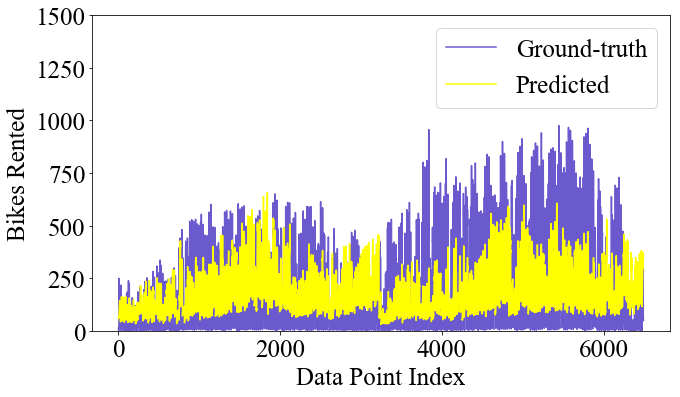

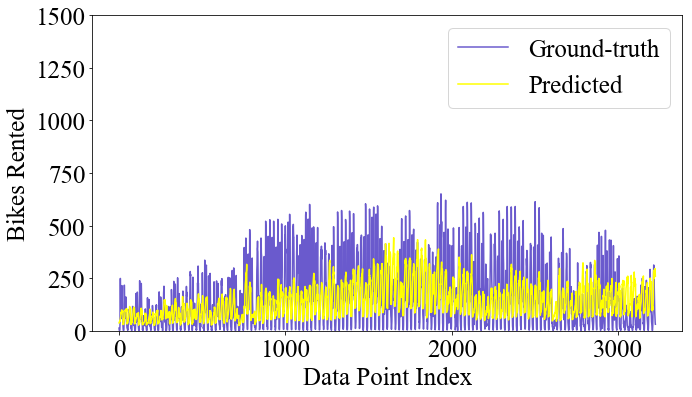

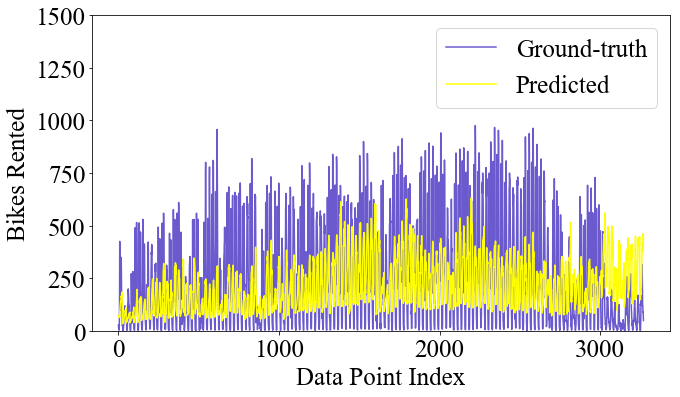

In [101]:
plot_series_compare(pred_test_all, y_test)
pyplot.savefig('all_series_test.jpg')
plot_series_compare(pred_test_2011, y_test_2011)
pyplot.savefig('2011_series_test.jpg')
plot_series_compare(pred_test_2012, y_test_2012)
pyplot.savefig('2012_series_test.jpg')

In [102]:
print_dispersion_stats(pred_test_all, y_test, X_test_scaled, 'All')
print_dispersion_stats(pred_test_2011, y_test_2011, X_test_scaled_2011, '2011')
print_dispersion_stats(pred_test_2012, y_test_2012, X_test_scaled_2012, '2012')

All:
D = 133.47937346268256
p = 0.0
X^2 = 865079.8194116456
df = 6481


2011:
D = 89.20587375864679
p = 0.0
X^2 = 286440.0606390148
df = 3211


2012:
D = 173.9259201050756
p = 0.0
X^2 = 566650.6477023363
df = 3258




In [183]:
print(get_RMSE(pred_test_all, y_train))
print(get_RMSE(pred_test_2011, y_train_2011))
print(get_RMSE(pred_test_2012, y_train_2012))

143.43691622571205
111.21365524683998
165.24420658084307


## Fit Negative Binomial Regression Model

In [275]:
# fit models using Negative Binomial regression

X_train_scaled = minmax_scaler.fit_transform(X_train)
X_train_scaled = pandas.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled['const'] = numpy.ones_like(X_train_scaled['month']) # add intercept 
model_all_nb = sm.GLM(y_train, X_train_scaled, family=sm.families.NegativeBinomial()).fit()
pred_train_all_nb = model_all_nb.predict()

X_train_scaled_2011 = minmax_scaler.fit_transform(X_train_2011)
X_train_scaled_2011 = pandas.DataFrame(X_train_scaled_2011, columns=X_train_2011.columns)
X_train_scaled_2011['const'] = numpy.ones_like(X_train_scaled_2011['month']) # add intercept 
model_2011_nb = sm.GLM(y_train_2011, X_train_scaled_2011, family=sm.families.NegativeBinomial()).fit()
pred_train_2011_nb = model_2011_nb.predict()

X_train_scaled_2012 = minmax_scaler.fit_transform(X_train_2012)
X_train_scaled_2012 = pandas.DataFrame(X_train_scaled_2012, columns=X_train_2012.columns)
X_train_scaled_2012['const'] = numpy.ones_like(X_train_scaled_2012['month']) # add intercept 
model_2012_nb = sm.GLM(y_train_2012, X_train_scaled_2012, family=sm.families.NegativeBinomial()).fit()
pred_train_2012_nb = model_2012_nb.predict()

In [276]:
print_dispersion_stats(pred_train_all_nb, y_train, X_train, 'All')
print_dispersion_stats(pred_train_2011_nb, y_train_2011, X_train_scaled_2011, '2011')
print_dispersion_stats(pred_train_2012_nb, y_train_2012, X_train_scaled_2012, '2012')

All:
D = 131.28317494298665
p = 0.0
X^2 = 1427704.5275049799
df = 10875


2011:
D = 83.72033603342743
p = 0.0
X^2 = 452927.01794084243
df = 5410


2012:
D = 145.50956855833644
p = 0.0
X^2 = 793318.1677800503
df = 5452




In [280]:
summary_all_nb = model_all_nb.summary()
results_as_html = summary_all_nb.tables[1].as_html()
summary_all_df_nb = pandas.read_html(results_as_html, header=0, index_col=0)[0]
summary_all_df_nb.to_csv('Poisson_all_summary_nb.csv')
summary_all_nb

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  count   No. Observations:                10886
Model:                            GLM   Df Residuals:                    10875
Model Family:        NegativeBinomial   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -65986.
Date:                Fri, 10 Dec 2021   Deviance:                       10642.
Time:                        14:07:08   Pearson chi2:                 1.11e+04
No. Iterations:                    15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
month          0.8593      0.131      6.551      0.000       0.602       1.116
hour           1.6494      0.034     48.649      0.000       1.583       1.716
season        -0.2795      0.110     -2.539      0.011      -0.495      -0.064
holiday       -0.0146      0.060     -0.244      0.808      -0.133       0.103
workingday     0.0720      0.021      3.370      0.001       0.030       0.114
weather       -0.1125      0.051     -2.209      0.027      -0.212      -0.013
temp           0.2962      0.296      1.002      0.316      -0.283       0.876
atemp          1.1981      0.303      3.958      0.000       0.605       1.791
humidity      -0.9841      0.062    -15.872      0.000      -1.106      -0.863
windspeed      0.1110      0.074      1.509      0.131      -0.033       0.255
const          3.7334      0.060     62.323      0.000       3.616       3.851
==============================================================================
"""

In [281]:
summary_2011_nb = model_2011_nb.summary()
results_as_html = summary_2011_nb.tables[1].as_html()
summary_2011_df_nb = pandas.read_html(results_as_html, header=0, index_col=0)[0]
summary_2011_df_nb.to_csv('Poisson_2011_summary_nb.csv')
summary_2011_nb

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 5422
Model:                            GLM   Df Residuals:                     5411
Model Family:        NegativeBinomial   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -31209.
Date:                Fri, 10 Dec 2021   Deviance:                       4780.2
Time:                        14:07:09   Pearson chi2:                 4.66e+03
No. Iterations:                    14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
month          0.8391      0.186      4.522      0.000       0.475       1.203
hour           1.6673      0.048     34.964      0.000       1.574       1.761
season        -0.1240      0.157     -0.792      0.428      -0.431       0.183
holiday        0.0218      0.088      0.246      0.805      -0.151       0.195
workingday     0.0470      0.030      1.549      0.121      -0.012       0.106
weather       -0.0829      0.047     -1.748      0.080      -0.176       0.010
temp          -0.7183      0.536     -1.340      0.180      -1.769       0.332
atemp          2.3060      0.562      4.105      0.000       1.205       3.407
humidity      -0.8804      0.085    -10.417      0.000      -1.046      -0.715
windspeed      0.2767      0.105      2.638      0.008       0.071       0.482
const          3.2421      0.084     38.645      0.000       3.078       3.407
==============================================================================
"""

In [282]:
summary_2012_nb = model_2012_nb.summary()
results_as_html = summary_2012_nb.tables[1].as_html()
summary_2012_df_nb = pandas.read_html(results_as_html, header=0, index_col=0)[0]
summary_2012_df_nb.to_csv('Poisson_2012_summary_nb.csv')
summary_2012_nb

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 5464
Model:                            GLM   Df Residuals:                     5453
Model Family:        NegativeBinomial   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -34428.
Date:                Fri, 10 Dec 2021   Deviance:                       5162.9
Time:                        14:07:09   Pearson chi2:                 4.85e+03
No. Iterations:                    15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
month          0.8596      0.188      4.566      0.000       0.491       1.229
hour           1.7270      0.048     35.641      0.000       1.632       1.822
season        -0.3520      0.157     -2.240      0.025      -0.660      -0.044
holiday       -0.0660      0.083     -0.799      0.424      -0.228       0.096
workingday     0.0825      0.030      2.728      0.006       0.023       0.142
weather       -0.1654      0.073     -2.252      0.024      -0.309      -0.021
temp           0.2814      0.342      0.823      0.411      -0.389       0.952
atemp          0.9276      0.349      2.661      0.008       0.244       1.611
humidity      -0.6873      0.079     -8.747      0.000      -0.841      -0.533
windspeed      0.1414      0.090      1.576      0.115      -0.034       0.317
const          3.8491      0.076     50.761      0.000       3.701       3.998
==============================================================================
"""

In [268]:
print(numpy.mean(y_train), numpy.mean(pred_train_all_nb))
print(numpy.mean(y_train_2011), numpy.mean(pred_train_2011_nb))
print(numpy.mean(y_train_2012), numpy.mean(pred_train_2012_nb))

191.57413191254824 199.21973028992176
144.223349317595 149.85026943522467
238.56094436310394 249.13257829149148


In [269]:
print(numpy.var(y_train), numpy.var(pred_train_all_nb))
print(numpy.var(y_train), numpy.var(pred_train_2011_nb))
print(numpy.var(y_train), numpy.var(pred_train_2012_nb))

32810.29888623418 17433.359009332835
32810.29888623418 10803.118017415141
32810.29888623418 24833.385961776537


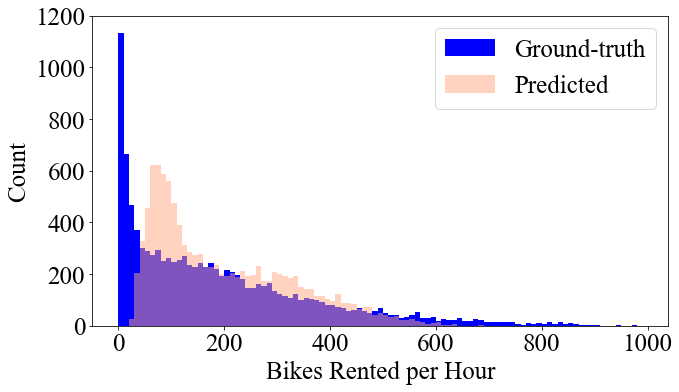

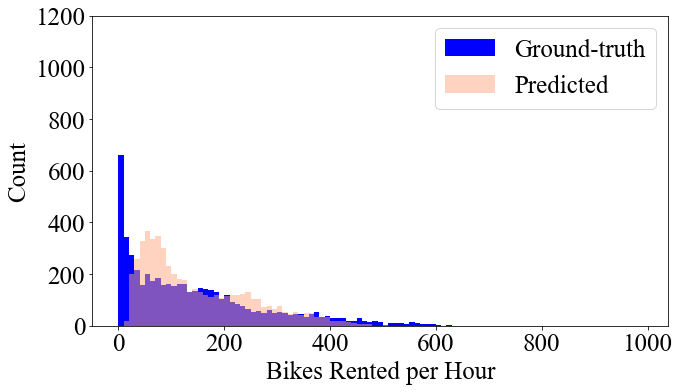

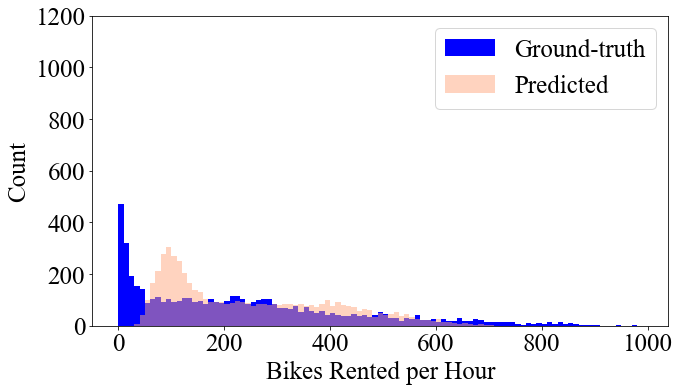

In [283]:
plot_dist_compare(pred_train_all_nb, y_train, 'Distribution of Bike Rentals per Hour')
pyplot.savefig('all_dist_nb.jpg')
plot_dist_compare(pred_train_2011_nb, y_train_2011, 'Distribution of Bike Rentals per Hour 2011')
pyplot.savefig('2011_dist_nb.jpg')
plot_dist_compare(pred_train_2012_nb, y_train_2012, 'Distribution of Bike Rentals per Hour 2012')
pyplot.savefig('2012_dist_nb.jpg')

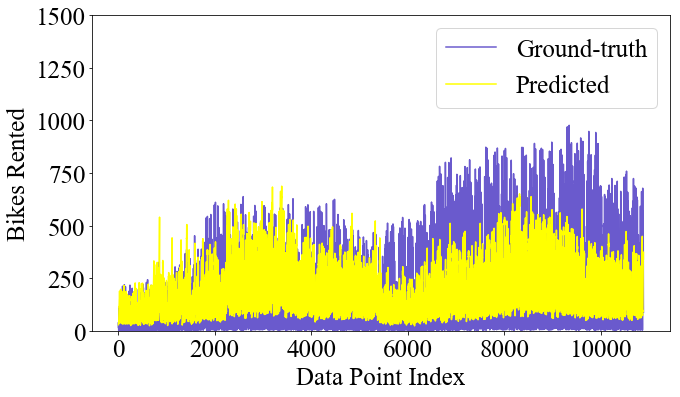

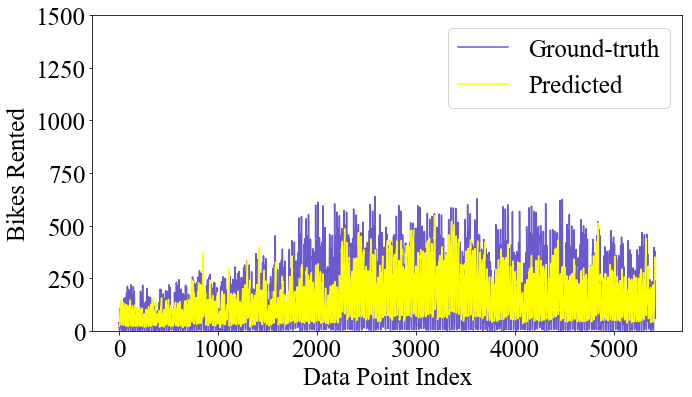

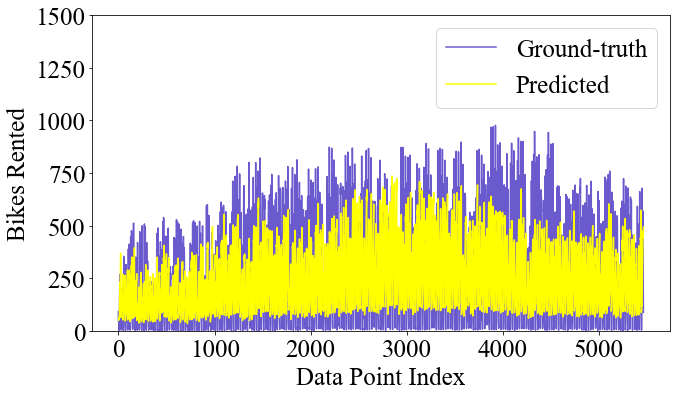

In [284]:
plot_series_compare(pred_train_all_nb, y_train)
pyplot.savefig('all_series_nb.jpg')
plot_series_compare(pred_train_2011_nb, y_train_2011)
pyplot.savefig('2011_series_nb.jpg')
plot_series_compare(pred_train_2012_nb, y_train_2012)
pyplot.savefig('2012_series_nb.jpg')

In [272]:
print(get_RMSE(pred_train_all_nb, y_train))
print(get_RMSE(pred_train_2011_nb, y_train_2011))
print(get_RMSE(pred_train_2012_nb, y_train_2012))

157.30363022347413
111.35188210115734
184.82895596951525


## Test Negative Binomial Regression Model

In [318]:
pred_test_all_nb = model_all_nb.predict(X_test_scaled)
pred_test_2011_nb = model_2011_nb.predict(X_test_scaled_2011)
pred_test_2012_nb = model_2012_nb.predict(X_test_scaled_2012)
print(get_RMSE(pred_test_all_nb, y_test))
print(get_RMSE(pred_test_2011_nb, y_test_2011))
print(get_RMSE(pred_test_2012_nb, y_test_2012))

167.05167220023938
118.4866946090901
191.13057808700358


## Fit XGBoost Model

In [312]:
import xgboost as xgb

X_train_scaled = minmax_scaler.fit_transform(X_train)
X_train_scaled = pandas.DataFrame(X_train_scaled, columns=X_train.columns)
# X_train_scaled['const'] = numpy.ones_like(X_train_scaled['month']) # add intercept 

X_train_scaled_2011 = minmax_scaler.fit_transform(X_train_2011)
X_train_scaled_2011 = pandas.DataFrame(X_train_scaled_2011, columns=X_train_2011.columns)
# X_train_scaled_2011['const'] = numpy.ones_like(X_train_scaled_2011['month']) # add intercept 

X_train_scaled_2012 = minmax_scaler.fit_transform(X_train_2012)
X_train_scaled_2012 = pandas.DataFrame(X_train_scaled_2012, columns=X_train_2012.columns)
# X_train_scaled_2012['const'] = numpy.ones_like(X_train_scaled_2012['month']) # add intercept 

xgbr_all = xgb.XGBRegressor(verbosity=0) 
xgbr_all.fit(X_train_scaled, y_train)
pred_train_all_x = xgbr_all.predict(X_train_scaled)

xgbr_2011 = xgb.XGBRegressor(verbosity=0) 
xgbr_2011.fit(X_train_scaled_2011, y_train_2011)
pred_train_2011_x = xgbr_2011.predict(X_train_scaled_2011)

xgbr_2012 = xgb.XGBRegressor(verbosity=0) 
xgbr_2012.fit(X_train_scaled_2012, y_train_2012)
pred_train_2012_x = xgbr_2012.predict(X_train_scaled_2012)

print_dispersion_stats(pred_train_all_x, y_train, X_train_scaled, 'All')
print_dispersion_stats(pred_train_2011_x, y_train_2011, X_train_scaled_2011, '2011')
print_dispersion_stats(pred_train_2012_x, y_train_2012, X_train_scaled_2012, '2012')

All:
D = 8.503125718390805
p = 0.0
X^2 = 92471.49
df = 10875


2011:
D = 6.618943121893062
p = 0.0
X^2 = 35815.10123256336
df = 5411


2012:
D = 2.082429666444053
p = 0.0
X^2 = 11355.488971119423
df = 5453




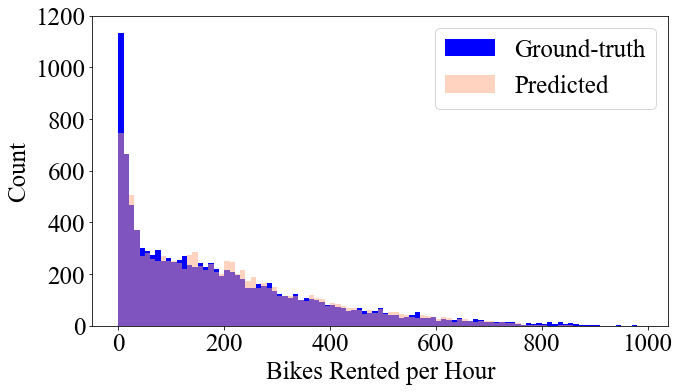

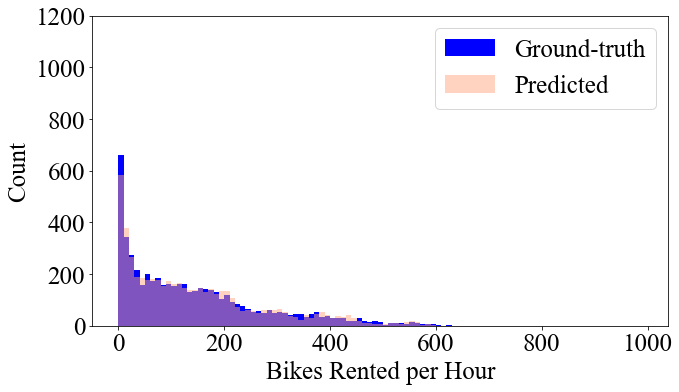

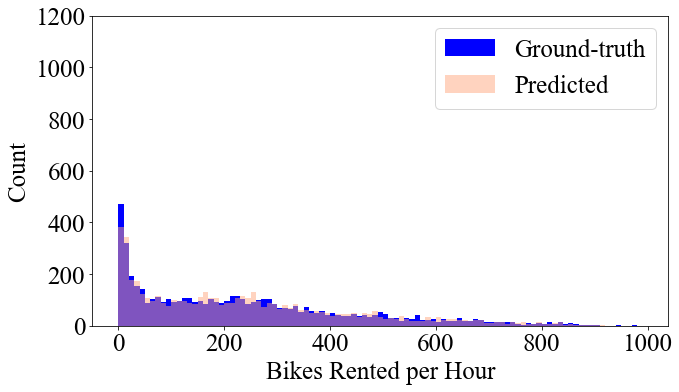

In [313]:
plot_dist_compare(pred_train_all_x, y_train, 'Distribution of Bike Rentals per Hour')
pyplot.savefig('all_dist_x.jpg')
plot_dist_compare(pred_train_2011_x, y_train_2011, 'Distribution of Bike Rentals per Hour 2011')
pyplot.savefig('2011_dist_x.jpg')
plot_dist_compare(pred_train_2012_x, y_train_2012, 'Distribution of Bike Rentals per Hour 2012')
pyplot.savefig('2012_dist_x.jpg')

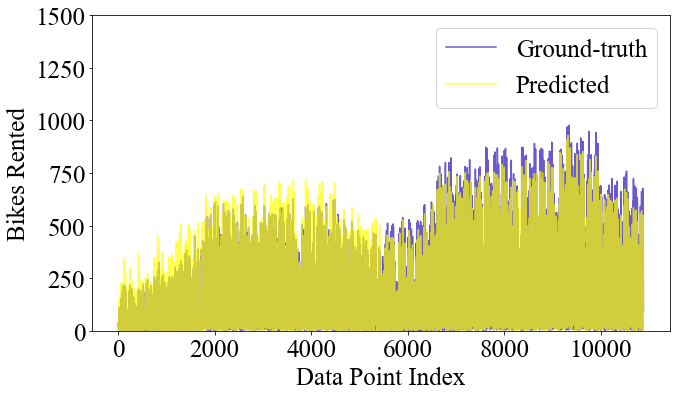

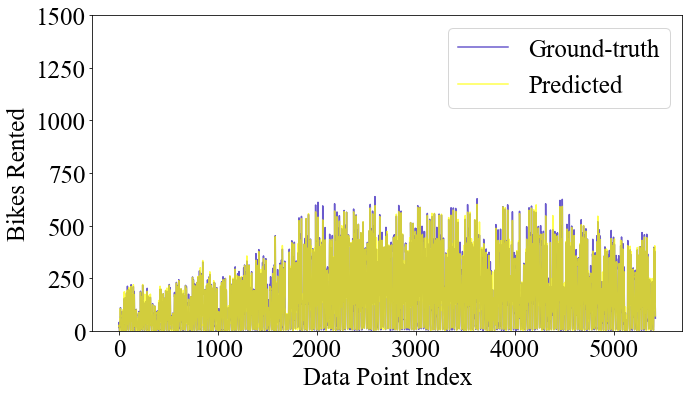

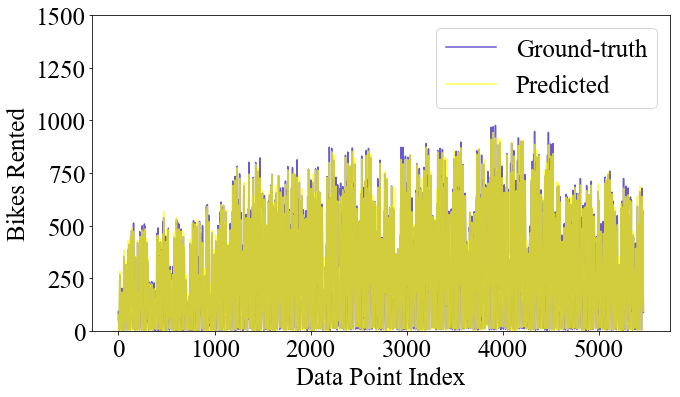

In [314]:
plot_series_compare(pred_train_all_x, y_train)
pyplot.savefig('all_series_x.jpg')
plot_series_compare(pred_train_2011_x, y_train_2011)
pyplot.savefig('2011_series_x.jpg')
plot_series_compare(pred_train_2012_x, y_train_2012)
pyplot.savefig('2012_series_x.jpg')

## Test XGBoost Model

In [315]:
pred_test_all_x = xgbr.predict(X_test_scaled)
pred_test_2011_x = xgbr.predict(X_test_scaled_2011)
pred_test_2012_x = xgbr.predict(X_test_scaled_2012)

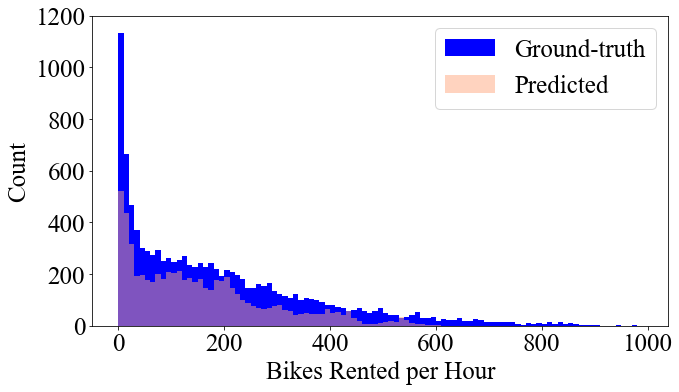

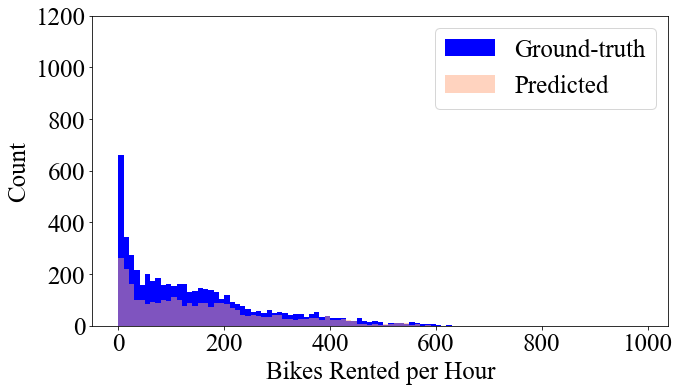

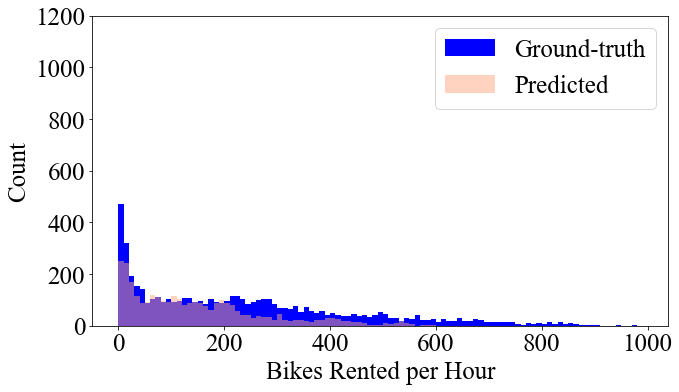

In [316]:
plot_dist_compare(pred_test_all_x, y_train, 'Distribution of Bike Rentals per Hour')
pyplot.savefig('all_dist_test_x.jpg')
plot_dist_compare(pred_test_2011_x, y_train_2011, 'Distribution of Bike Rentals per Hour 2011')
pyplot.savefig('2011_dist_test_x.jpg')
plot_dist_compare(pred_test_2012_x, y_train_2012, 'Distribution of Bike Rentals per Hour 2012')
pyplot.savefig('2012_dist_test_x.jpg')

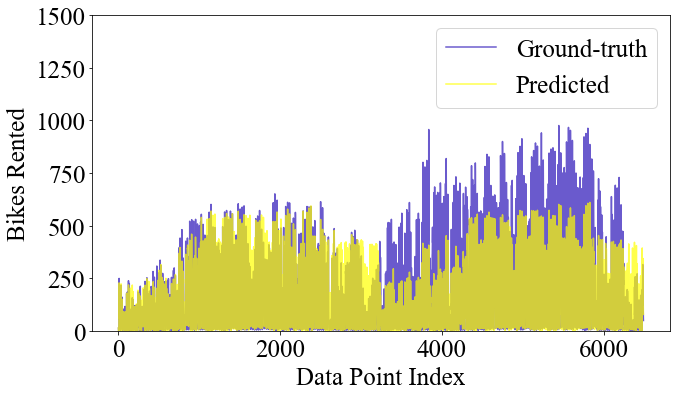

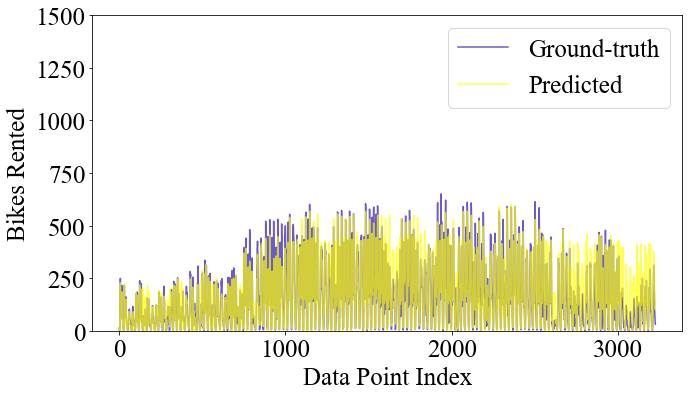

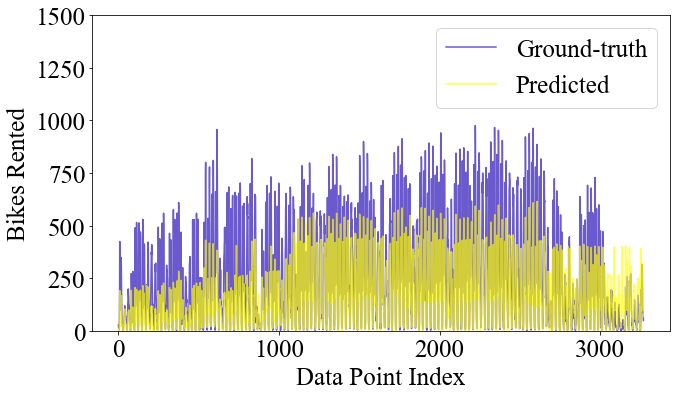

In [317]:
plot_series_compare(pred_test_all_x, y_test)
pyplot.savefig('all_series_test_x.jpg')
plot_series_compare(pred_test_2011_x, y_test_2011)
pyplot.savefig('2011_series_test_x.jpg')
plot_series_compare(pred_test_2012_x, y_test_2012)
pyplot.savefig('2012_series_test_x.jpg')

In [319]:
print(get_RMSE(pred_test_all_x, y_test))
print(get_RMSE(pred_test_2011_x, y_test_2011))
print(get_RMSE(pred_test_2012_x, y_test_2012))

99.67716032298497
55.209995494073205
133.8390486862216
